In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
from iminuit import Minuit
import scipy.integrate as si

# Part 1

### Starting Functions Defined in this Cell

In [2]:
def pdf(t,v,tau,m,t_range):
    """This function defines the normalised pdf"""
    a,b = t_range
    integral = lambda x: -(tau*np.exp(-x/tau)*(m**2*tau**2+m*tau*v*np.cos(m*x)+v*np.sin(m*x)+1))/(m**2*tau**2+1)
    norm = 1/(integral(b) - integral(a))
    return norm*(1+v*np.sin(m*t))*np.exp(-t/tau)

def negative_pdf(t,args):
    """This function defines a negative pdf (for minimisation)"""
    v,m,tau,a,b = args
    integral = lambda x: -(tau*np.exp(-x/tau)*(m**2*tau**2+m*tau*v*np.cos(m*x)+v*np.sin(m*x)+1))/(m**2*tau**2+1)
    norm = 1/(integral(b) - integral(a))
    return -norm*(1+v*np.sin(m*t))*np.exp(-t/tau)

#Function draws random number from distribution using box method
def monte_carlo(v,tau,m,t_range,n):
    """Using the box method monte carlo, this function creates data corresponding to the pdf"""
    distribution = []
    a,b = t_range
    fmax = -sp.minimize(negative_pdf,0.1,args=([v,m,tau,a,b]),bounds=((a,b),)).fun #define the range of the "box"
    
    #while loop ensures n numbers are returned
    while len(distribution) < n:
        x1 = a+(b-a)*np.random.uniform(1,0) #defines a random number in the range [a,b]
        y1 = pdf(x1,v,tau,m,t_range) #corresponding y1 in the exp distribution
        y2 = np.random.uniform(1,0)*fmax #Random number inside "box"
        
        #if statement only returns y2 values within distribution 
        if y2 < y1:
            distribution.append(x1)
            
    return distribution

### Testing to Ensure Monte Carlo Gives Good Results

In [3]:
# Define the parameters
v = 0.1
tau = 1.5
m = 20.
t_range = (0,10)
n = 10000

# producing the data
data = monte_carlo(v,tau,m,t_range,n)

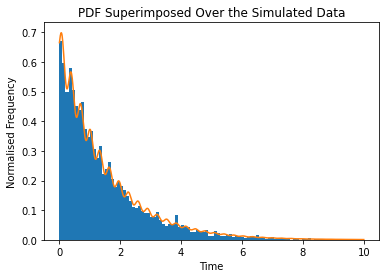

In [4]:
values = np.linspace(0,10,1000)
plt.hist(data,bins=100,density=True) # Normalise the histogram
plt.plot(values,pdf(values,v,tau,m,t_range))
plt.xlabel("Time")
plt.ylabel("Normalised Frequency")
plt.title("PDF Superimposed Over the Simulated Data")
plt.show()
# The curve shows good correlation with the data

In [5]:
def maximum_likelihood_ten(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for 10,000 particles"""
    t_range = (a,b)
    func = pdf(data_ten_thou,v,tau,m,t_range)
    func[func < 1e-4] = 1e-4 # Clip values too small for the logarithm
    return -np.sum(np.log(func))


def maximum_likelihood_hun(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for 100,000 particles"""
    t_range = (a,b)
    func = pdf(data_hundred_thou,v,tau,m,t_range)
    func[func < 1e-4] = 1e-4 # Clip values too small for the logarithm
    return -np.sum(np.log(func))

#Re-define the parameters for clarity
v = 0.1
tau = 1.5
m = 20.
a = 0
b = 10
t_range = (a,b)

#Set errors to give 
maximum_likelihood_ten.errordef = Minuit.LIKELIHOOD
maximum_likelihood_hun.errordef = Minuit.LIKELIHOOD

#initialise arrays of the values
v_ten = []
tau_ten = []
m_ten = []
v_hun = []
tau_hun = []
m_hun = []



for i in range(100):
    #Simulate the data
    data_ten_thou = np.asarray(monte_carlo(v,tau,m,t_range,n=10000))
    data_hundred_thou = np.asarray(monte_carlo(v,tau,m,t_range,n=100000))

    #define the minimisation with Minuit
    ten_thou = Minuit(maximum_likelihood_ten,v=v,tau=tau,m=m,a=a,b=b)
    hundred_thou = Minuit(maximum_likelihood_hun,v=v,tau=tau,m=m,a=a,b=b)

    # Fix the parameters a & b to not be minimised
    ten_thou.fixed['a','b'] = True
    hundred_thou.fixed['a','b'] = True
    
    # Run the minimisation
    ten_thou.migrad()
    hundred_thou.migrad()
    
    #append to the arrays
    v_ten.append(ten_thou.values[0])
    tau_ten.append(ten_thou.values[1])
    m_ten.append(ten_thou.values[2])
    v_hun.append(hundred_thou.values[0])
    tau_hun.append(hundred_thou.values[1])
    m_hun.append(hundred_thou.values[2])

In [8]:
#Calculate average values for parameters

param_v_ten,param_v_hun = np.mean(np.asarray(v_ten)),np.mean(np.asarray(v_hun))
param_tau_ten,param_tau_hun = np.mean(np.asarray(tau_ten)),np.mean(np.asarray(tau_hun))
param_m_ten,param_m_hun = np.mean(np.asarray(m_ten)),np.mean(np.asarray(m_hun))

#Calculate statistical errors on the parameters by taking the standard deviation

error_v_ten,error_v_hun = np.std(np.asarray(v_ten)),np.std(np.asarray(v_hun))
error_tau_ten,error_tau_hun = np.std(np.asarray(tau_ten)),np.std(np.asarray(tau_hun))
error_m_ten,error_m_hun = np.std(np.asarray(m_ten)),np.std(np.asarray(m_hun))


print("Comparison of Parameter Values for 10,000 vs 100,000 Events are: \n")
print("V = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(param_v_ten,param_v_hun))
print("tau = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(param_tau_ten,param_tau_hun))
print("delta m = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(param_m_ten,param_m_hun))

print("")
print("")

print("Comparison of Parameter Errors for 10,000 vs 100,000 Events are: \n")
print("V = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(error_v_ten,error_v_hun))
print("tau = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(error_tau_ten,error_tau_hun))
print("delta m = {:.4f} (10,000 events) and {:.4f} (100,000 events)".format(error_m_ten,error_m_hun))

Comparison of Parameter Values for 10,000 vs 100,000 Events are: 

V = 0.1014 (10,000 events) and 0.0999 (100,000 events)
tau = 1.5018 (10,000 events) and 1.5007 (100,000 events)
delta m = 20.0028 (10,000 events) and 20.0002 (100,000 events)


Comparison of Parameter Errors for 10,000 vs 100,000 Events are: 

V = 0.0142 (10,000 events) and 0.0042 (100,000 events)
tau = 0.0143 (10,000 events) and 0.0044 (100,000 events)
delta m = 0.0658 (10,000 events) and 0.0225 (100,000 events)


The errors given above tell us the precision with which we can find the parameters if we were to do the experiment for real, given perfect detector resolutions. The parameter values correspond well with each other and the actual parameter values (being equal to at least 1 significant figure) with which the data was simulated, meaning the minimisation ran well.  

It is clear to see that with more data points, the fitting ran better as fitting to 100,000 data points correlated with lower statistical errors on the parameters than with 10,000 points. In fact, the parameter errors appear to decrease by roughly a factor 3 when the number of events increased from 10,000 to 100,000. This follows poissonian statistics (which governs the probability of a particle decay) which states that the error decreases by a factor $\sqrt{n}$ so an increase in events by a factor 10 corresponds to a decrease in error by a factor $\sqrt{10} \approx 3$. 

To summarise, when measuring the decay times of particle X, all the parameter values can be found with a precision of 2 significant figures and, in the case of V and $\tau$ with 100,000 events, to 3 significant figures.


# Part 2

In [9]:
def monte_carlo_time(v,tau,m,t_range,n,frac):
    """The same Monte Carlo function as above except this one adds a time resolution to the simulation"""
    distribution_b = []
    distribution_g = []
    a,b = t_range
    fmax = -sp.minimize(negative_pdf,0.1,args=([v,m,tau,a,b]),bounds=((a,b),)).fun #define the range of the "box"
    
    #while loop ensures n numbers are returned
    while len(distribution_b) < n:
        x1 = a+(b-a)*np.random.uniform(1,0) #defines a random number in the range [a,b]
        y1 = pdf(x1,v,tau,m,t_range) #corresponding y1 in the exp distribution
        y2 = np.random.uniform(1,0)*fmax #Random number inside "box"
        
        #if statement only returns y2 values within distribution 
        if y2 < y1:
            # Picks a random time from gaussian distribution to simulate a finite time resolution
            distribution_g.append(x1)
            distribution_b.append(np.random.normal(x1,frac*tau)) 
            
    return distribution_b,distribution_g

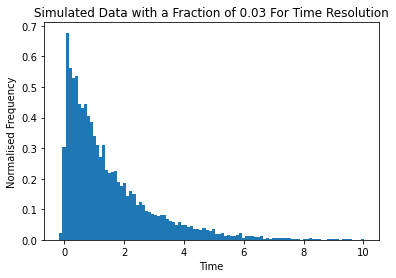

In [10]:
#This cell creates the data with finite time resolution to check 
frac1 = 0.01
frac2 = 0.03
n=10000 # Use 10,000 events
data_time1,wack = np.asarray(monte_carlo_time(v,tau,m,t_range,n,frac1))
data_time2,nope = np.asarray(monte_carlo_time(v,tau,m,t_range,n,frac2))

plt.hist(data_time2,bins=100,density=True)
plt.xlabel("Time")
plt.ylabel("Normalised Frequency")
plt.title("Simulated Data with a Fraction of 0.03 For Time Resolution")
plt.show()

#The oscillations are "smeared" out as the time resolution affects the finer details

In [11]:
#Finding the bias on the parameters:

def maximum_likelihood_bias1(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for data with time resolution (f=0.01)"""
    t_range = (a,b)
    func = pdf(data_time1_b,v,tau,m,t_range)
    func[func < 1e-5] = 1e-5 # Clip values too small for the logarithm
    return -np.sum(np.log(func))

def maximum_likelihood_bias2(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for data with time resolution (f=0.03)"""
    t_range = (a,b)
    func = pdf(data_time2_b,v,tau,m,t_range)
    func[func < 1e-5] = 1e-5 # Clip values too small for the logarithm
    return -np.sum(np.log(func))

def maximum_likelihood_good1(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for data with no time resolution"""
    t_range = (a,b)
    func = pdf(data_time1_g,v,tau,m,t_range)
    func[func < 1e-5] = 1e-5 # Clip values too small for the logarithm
    return -np.sum(np.log(func))

def maximum_likelihood_good2(v,tau,m,a,b):
    """Returns the maximum likelihood of the pdf for data with no time resolution"""
    t_range = (a,b)
    func = pdf(data_time2_g,v,tau,m,t_range)
    func[func < 1e-5] = 1e-5 # Clip values too small for the logarithm
    return -np.sum(np.log(func))

#Define the error for Minuit
maximum_likelihood_bias1.errordef = Minuit.LIKELIHOOD
maximum_likelihood_bias2.errordef = Minuit.LIKELIHOOD
maximum_likelihood_good1.errordef = Minuit.LIKELIHOOD
maximum_likelihood_good2.errordef = Minuit.LIKELIHOOD

bias1v = []
bias2v = []
bias1tau = []
bias2tau = []
bias1m = []
bias2m = []

good1v = []
good2v = []
good1tau = []
good2tau = []
good1m = []
good2m = []

#Run it 200 times to get 200 parameters
for i in range(200):
    # create data
    data_time1_b,data_time1_g = np.asarray(monte_carlo_time(v,tau,m,t_range,n,frac1))
    data_time2_b,data_time2_g = np.asarray(monte_carlo_time(v,tau,m,t_range,n,frac2))
    # initialise minuit
    minimum1_b = Minuit(maximum_likelihood_bias1,v=v,tau=tau,m=m,a=a,b=b)
    minimum2_b = Minuit(maximum_likelihood_bias2,v=v,tau=tau,m=m,a=a,b=b)
    minimum1_g = Minuit(maximum_likelihood_good1,v=v,tau=tau,m=m,a=a,b=b)
    minimum2_g = Minuit(maximum_likelihood_good2,v=v,tau=tau,m=m,a=a,b=b)
    # fix parameters
    minimum1_b.fixed['a','b'] = True
    minimum2_b.fixed['a','b'] = True
    minimum1_g.fixed['a','b'] = True
    minimum2_g.fixed['a','b'] = True
    # run the minimisation
    minimum1_b.migrad()
    minimum2_b.migrad()
    minimum1_g.migrad()
    minimum2_g.migrad()
    # save the parameters
    bias1v.append(minimum1_b.values[0])
    bias2v.append(minimum2_b.values[0])
    bias1tau.append(minimum1_b.values[1])
    bias2tau.append(minimum2_b.values[1])
    bias1m.append(minimum1_b.values[2])
    bias2m.append(minimum2_b.values[2])
    good1v.append(minimum1_g.values[0])
    good2v.append(minimum2_g.values[0])
    good1tau.append(minimum1_g.values[1])
    good2tau.append(minimum2_g.values[1])
    good1m.append(minimum1_g.values[2])
    good2m.append(minimum2_g.values[2])

In [22]:
# find the bias
b1v,b2v = np.mean(np.array(bias1v)-np.array(good1v)),np.mean(np.array(bias2v)-np.array(good2v))
b1t,b2t = np.mean(np.array(bias1tau)-np.array(good1tau)),np.mean(np.array(bias2tau)-np.array(good2tau))
b1m,b2m = np.mean(np.array(bias1m)-np.array(good1m)),np.mean(np.array(bias2m)-np.array(good2m))

#finding error on the bias
e1v,e2v = np.std(np.array(bias1v)-np.array(good1v))/np.sqrt(200),np.std(np.array(bias2v)-np.array(good2v))/np.sqrt(200)
e1t,e2t = np.std(np.array(bias1tau)-np.array(good1tau))/np.sqrt(200),np.std(np.array(bias2tau)-np.array(good2tau))/np.sqrt(200)
e1m,e2m = np.std(np.array(bias1m)-np.array(good1m))/np.sqrt(200),np.std(np.array(bias2m)-np.array(good2m))/np.sqrt(200)

#finding statistical errors on the parameters
s1v,s2v = np.std(bias1v),np.std(bias2v)
s1t,s2t = np.std(bias1tau),np.std(bias2tau)
s1m,s2m = np.std(bias1m),np.std(bias2m)

print("Parameter Values for f=0.01 Along With Statistical Errors and Corresponding Bias Are:\n")
print("V = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f},".format(np.mean(bias1v),s1v,b1v,e1v))
print("tau = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f}".format(np.mean(bias1tau),s1t,b1t,e1t))
print("delta m = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f}".format(np.mean(bias1m),s1m,b1m,e1m))
print("")
print("Parameter Values for f=0.03 Along With Statistical Errors and Corresponding Bias Are:\n")
print("V = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f}".format(np.mean(bias2v),s2v,b2v,e2v))
print("tau = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f}".format(np.mean(bias2tau),s2t,b2t,e2t))
print("delta m = {:.4f}, Statistical Error = {:.4f}, Bias = {:.4f}, Error on Bias = {:.4f}".format(np.mean(bias2m),s2m,b2m,e2m))

Parameter Values for f=0.01 Along With Statistical Errors and Corresponding Bias Are:

V = 0.0921, Statistical Error = 0.0141, Bias = -0.0069, Error on Bias = 0.0003,
tau = 1.5011, Statistical Error = 0.0163, Bias = -0.0004, Error on Bias = 0.0000
delta m = 20.0004, Statistical Error = 0.0782, Bias = -0.0004, Error on Bias = 0.0019

Parameter Values for f=0.03 Along With Statistical Errors and Corresponding Bias Are:

V = 0.0457, Statistical Error = 0.0144, Bias = -0.0564, Error on Bias = 0.0009
tau = 1.4982, Statistical Error = 0.0150, Bias = -0.0029, Error on Bias = 0.0001
delta m = 19.9705, Statistical Error = 0.1475, Bias = -0.0168, Error on Bias = 0.0091


The biases are small but the errors on the biases are even smaller, except for $\Delta m$. Unlike for V and $\tau$ where we can be reasonably certain on the bias, $\Delta m$ has an error which is either close to, or even exceeds, the value of the actual bias. For some reason, Minuit struggles to consistently determine an accurate value for $\Delta m$ meaning that it is impossible to tell the exact value for the bias. The reason is likely because $\Delta m$ has a large value within the sine function, meaning that a slight variation in t causes a wildly different value for $\sin{\Delta mt}$. This, therefore, causes the best value of $\Delta m$ to change a lot thus producing a wide width of $\Delta m$ values. As a result, it is difficult to tell if the bias on $\Delta m$ will be large or not as it greatly depends on which values of t are more skewed during a particular run. This is also reflected in the statistical error which is far greater — by a factor 10 in the case of f = 0.03 — than the the error in the other parameters.  

Comparing these biases with the statistical errors on the parameters, we find that for $\tau$ and $\Delta m$, the bias is dwarfed by those values whereas for V, the bias can be almost 5 times as large! This implies that the time resolution will greatly affect the fitted value for V, whilst for the others the random statistical error will dominate. A possible reason is that the time resolution "smears" out the waves in the slope. This doesn't affect the overall shape much (hence $\tau$ has the smallest bias) but it does make the finer features, i.e., the periodic parts, change. The greatest bias can be found in the V parameter which is not too surprising as the amplitude of the wave changes due to the "smearing" inducing a smoothing of the curve whilst the period of oscillation does not change as much as the amplitude. Because of this, V has the highest bias, followed by $\Delta m$ and $\tau$ has a very small bias.

The biases increase as the fraction, f, increases which is to be expected as an increasing bias coincides with a decreasing time resolution. The bias on $\delta m$ increases the least (although we cannot know for sure due to the high uncertainty) whereas the bias on V increases the most.  

# Part 3

In [13]:
#Time acceptance is multiplied by the pdf

def pdf_ta(t,v,tau,m,t_range,s):
    """Defines the pdf multiplied by the time acceptance function"""
    a,b = t_range
    func = lambda x: (1+s*x)*(1+v*np.sin(m*x))*np.exp(-x/tau)
    norm = 1/(si.quad(func,a,b)[0]) # normalises the pdf
    return norm*func(t)

def negative_pdf_ta(t,args):
    """Defines the same pdf as above but negative (for finding fmax)"""
    v,m,tau,a,b,s = args
    func = lambda x: (1+s*x)*(1+v*np.sin(m*x))*np.exp(-x/tau)
    norm = 1/(si.quad(func,a,b)[0]) # normalises the pdf
    return -norm*func(t)

#Function draws random number from distribution using box method
def monte_carlo_ta(v,tau,m,t_range,n,s):
    """Monte Carlo function that returns data corresponding to pdf with time acceptance function"""
    distribution = []
    a,b = t_range
    fmax = -sp.minimize(negative_pdf_ta,0.1,args=([v,m,tau,a,b,s]),bounds=((a,b),)).fun #define the range of the "box"
    func = lambda x: (1+s*x)*(1+v*np.sin(m*x))*np.exp(-x/tau)
    norm = 1/(si.quad(func,a,b)[0]) # normalises the pdf
    
    #while loop ensures n numbers are returned
    while len(distribution) < n:
        x1 = a+(b-a)*np.random.uniform(1,0) #defines a random number in the range [a,b]
        y1 = norm*func(x1) #corresponding y1 in the exp distribution
        y2 = np.random.uniform(1,0)*fmax #Random number inside "box"
        
        #if statement only returns y2 values within distribution 
        if y2 < y1:
            distribution.append(x1)
            
    return distribution

def maximum_likelihood_ta(v,tau,m,a,b,s):
    """Returns the maximum likelihood of the pdf for data with time acceptance function"""
    t_range = (a,b)
    func = pdf_ta(ta_data,v,tau,m,t_range,s)
    func[func < 1e-4] = 1e-4 # Clip values too small for the logarithm
    return -np.sum(np.log(func))


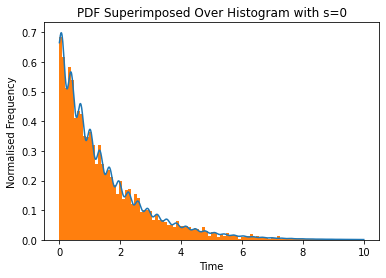

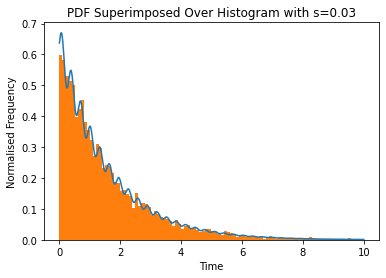

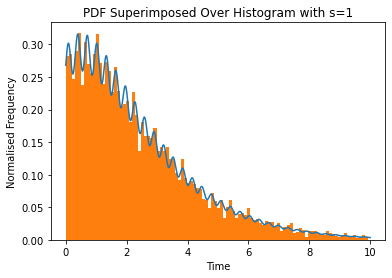

In [14]:
#re-define the parameters
v = 0.1
tau = 1.5
m = 20.
a = 0
b = 10
t_range = (a,b)
s = 0
s_err = 0.03

data_z = monte_carlo_ta(v,tau,m,t_range,10000,s)     # Monte Carlo for s=0
data_f = monte_carlo_ta(v,tau,m,t_range,10000,s_err) # Monte Carlo for s=0.03
data_o = monte_carlo_ta(v,tau,m,t_range,10000,1)     # Monte Carlo for s=1


#plot the values with time acceptance functions to check
plt.plot(values,pdf_ta(values,v,tau,m,t_range,s))
plt.hist(data_z,bins=100,density=True)
plt.xlabel("Time")
plt.ylabel("Normalised Frequency")
plt.title("PDF Superimposed Over Histogram with s=0")
plt.show()

plt.plot(values,pdf_ta(values,v,tau,m,t_range,s_err))
plt.hist(data_f,bins=100,density=True)
plt.xlabel("Time")
plt.ylabel("Normalised Frequency")
plt.title("PDF Superimposed Over Histogram with s=0.03")
plt.show()

plt.plot(values,pdf_ta(values,v,tau,m,t_range,1))
plt.hist(data_o,bins=100,density=True)
plt.xlabel("Time")
plt.ylabel("Normalised Frequency")
plt.title("PDF Superimposed Over Histogram with s=1")
plt.show()

By increasing s, the histogram becomes shorter and wider as the time acceptance function is a straight line that is multiplied by the original pdf. This causes the graph to be linear (with sine curves) at very low t before the exponential takes over at higher t and we get a exponentially decreasing curve (with sine curves) again. This is exactly as we observe above so we know the pdf(t)$\cdot$a(t) runs as expected.

In [15]:
v = 0.1
tau = 1.5
m = 20.
a = 0
b = 10
t_range = (a,b)
n = 10000
s = 0
s_err = 0.03

#generates data for the function with no time acceptance
ta_data = np.asarray(monte_carlo_ta(v,tau,m,t_range,n,s))

# Using the simplistic method:

#For the first run, we use our value of s equal to 0 and fit the parameters

#fitting for the time acceptance
maximum_likelihood_ta.errordef = Minuit.LIKELIHOOD # Tells Minuit to use log-likelihood for the error matrix (0.5)

#Values for pdf without error
mta = Minuit(maximum_likelihood_ta,v=v,tau=tau,m=m,a=a,b=b,s=s) # Uses log-likelihood function with the stated guesses
mta.fixed['a','b','s'] = True
mta.migrad() # runs the minimisation

#Now we run it with s equal to the s+s_error and find the parameter

#Values for pdf with positive error
mta2 = Minuit(maximum_likelihood_ta,v=v,tau=tau,m=m,a=a,b=b,s=s+s_err) #Uses the value plus error as starting guess
mta2.fixed['a','b','s'] = True
mta2.migrad() # runs the minimisation

#Values for pdf with negative error
mta3 = Minuit(maximum_likelihood_ta,v=v,tau=tau,m=m,a=a,b=b,s=s-s_err) #Uses the value minus error as starting guess
mta3.fixed['a','b','s'] = True
mta3.migrad() # runs the minimisation

mta_ave = np.sqrt(np.square(np.asarray(mta2.values))+np.square(np.asarray(mta3.values)))

#Finding the difference between the two values gives the systematic error
sys_err = abs(np.asarray(mta2.values)-np.asarray(mta.values))

In [16]:
#check to see if +/- is similar
print("Raw Values\n")
print("For s+s_err:")
print("v = {:}, tau = {:}, dm = {:}".format(mta2.values[0],mta2.values[1],mta2.values[2]))
print("For s-s_err:")
print("v = {:}, tau = {:}, dm = {:}\n".format(mta3.values[0],mta3.values[1],mta3.values[2]))

print("Difference\n")
print("For s+s_err:")
print("v = {:}, tau = {:}, dm = {:}".format(mta2.values[0]-mta.values[0],mta2.values[1]-mta.values[1],
                                            mta2.values[2]-mta.values[2]))
print("For s-s_err:")
print("v = {:}, tau = {:}, dm = {:}".format(mta3.values[0]-mta.values[0],mta3.values[1]-mta.values[1],
                                            mta3.values[2]-mta.values[2]))

# These values are in reasonable agreement with each other with s+s_err being approximately equal to, or at least
# as far below, the true value as s-s_err is above it .

Raw Values

For s+s_err:
v = 0.08156799771613228, tau = 1.451209796295804, dm = 20.06321108287477
For s-s_err:
v = 0.08160717399235595, tau = 1.59116042097586, dm = 20.06314813979651

Difference

For s+s_err:
v = 9.533006350388729e-05, tau = -0.06088644183055214, dm = 8.633674878311126e-05
For s-s_err:
v = 0.0001345063397275581, tau = 0.079064182849504, dm = 2.3393670524285426e-05


In [17]:
print("Errors on Parameters are:\n")
print("V = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[0],mta.errors[0],sys_err[0]))
print("tau = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[1],mta.errors[1],sys_err[1]))
print("dm = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[2],mta.errors[2],sys_err[2]))

#Key: Parameter = Value +/- Statistical Error +/- Systematic Error"

Errors on Parameters are:

V = 0.0815 +/- 0.0142 +/- 0.0001
tau = 1.5121 +/- 0.0156 +/- 0.0609
dm = 20.0631 +/- 0.0672 +/- 0.0001


The systematic errors on V and $\Delta m$ are minuscule whilst the systematic error on $\tau$ is huge compared to its statistical error. This is to be expected as the sinusoid part of the function is not greatly affected by the time acceptance function. As can be seen in the plots above, the oscillation frequency doesn't change at all due to the fact it's inside the sine function and so the frequency is unaffected by the time acceptance function. The only power it holds over sine is changing the amplitude.

$\tau$, on the other hand, is more sensitive to changes to the overall function shape, which is what occurs when the pdf is multiplied by the time acceptance function (c.f. the graph above). As a result, it is expected that the systematic error for tau is greater then the others; in fact, it's greater than its statistical error meaning that the imperfectiveness of the measurement will induce a regular systematic error in the sampling of the data.

Thus, if we want to measure a reliable value of $\tau$ that lies within the statistical error, we must constrain the value of s to a more accurate value. For V and $\Delta m$, this will not be necessary as the statistical error will be the main hurdle to overcome. 

In [23]:
#Doing same thing but with method 2

#Create a gaussian distribution centred on the mean and with width equal to the error on the mean
#Then pick values of G inside and run the fit
shift_v = []
shift_tau = []
shift_m = []
count = 0

while count<100: # Do this 100 times
    g = np.random.normal(loc=s,scale=s_err) # pick value of s from gaussian distribution
    ml2 = Minuit(maximum_likelihood_ta,v=v,tau=tau,m=m,a=a,b=b,s=s) # Uses log-likelihood function with the stated guesses
    ml2.fixed['a','b','s'] = True # fix s as a constant parameter 
    ml2.migrad() # runs the minimisation
    ml3 = Minuit(maximum_likelihood_ta,v=v,tau=tau,m=m,a=a,b=b,s=g) # Uses log-likelihood with random s
    ml3.fixed['a','b','s'] = True
    ml3.migrad() 
    # append the shifts to their respective parameters
    shift_v.append(np.asarray(ml2.values[0])-np.asarray(ml3.values[0]))
    shift_tau.append(np.asarray(ml2.values[1])-np.asarray(ml3.values[1]))
    shift_m.append(np.asarray(ml2.values[2])-np.asarray(ml3.values[2]))
    count+=1

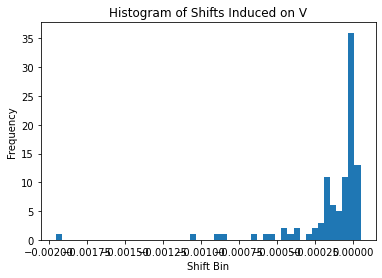

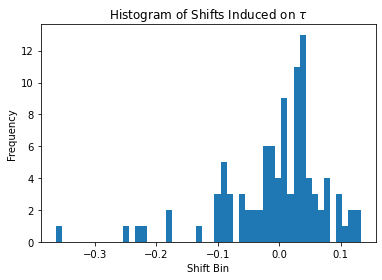

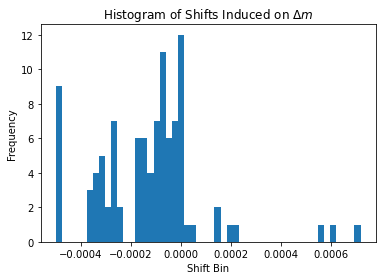

In [24]:
# Plot histograms of the shifts to ensure they are Gaussian

plt.hist(shift_v,bins=50)
plt.title("Histogram of Shifts Induced on V")
plt.xlabel("Shift Bin")
plt.ylabel("Frequency")
plt.show()

plt.hist(shift_tau,bins=50)
plt.title(r"Histogram of Shifts Induced on $\tau$")
plt.xlabel("Shift Bin")
plt.ylabel("Frequency")
plt.show()

plt.hist(shift_m,bins=50)
plt.title("Histogram of Shifts Induced on $\Delta m$")
plt.xlabel("Shift Bin")
plt.ylabel("Frequency")
plt.show()

These are supposed to look Gaussian. They look pretty close to gaussians so the method appears to have worked succesfully. Peculiarly, however, the graph of V appears to rarely go above 0 (in some runs, it never goes above 0) implying that the value of V calculated for s=0 is often (always) smaller than for s$\neq$0. Alas, I cannot think of a reason for this. Initially, I suspected it was because (1+st) will always result in a value larger than 1 (which you get for s=0) for any value between s+s_err. However, due to the nature of a Gaussian distribution centred on 0, it is also possible to get negative values meaning we also have values between s-s_err. Now (1+st) will always be smaller than 0 and so it should then lead to a lower amplitude and, therefore, a lower V. Evidently, that is not the case as even negative s leads to a greater value for V. Thus, this mystery remains unsolved :(

In [25]:
#systematic errors are their standard deviations
sysv = np.std(shift_v)
systau = np.std(shift_tau)
sysm = np.std(shift_m)



print("Errors on Parameters are:\n")
print("V = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[0],mta.errors[0],sysv))
print("tau = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[1],mta.errors[1],systau))
print("dm = {:.4f} +/- {:.4f} +/- {:.4f}".format(mta.values[2],mta.errors[2],sysm))

#Key: Parameter = Value +/- Statistical Error +/- Systematic Error"

Errors on Parameters are:

V = 0.0815 +/- 0.0142 +/- 0.0003
tau = 1.5121 +/- 0.0156 +/- 0.0820
dm = 20.0631 +/- 0.0672 +/- 0.0002


These values, calculated via a Gaussian method, are in good agreement with the values found via method 1. As a result, the conclusion remains the same so $\tau$ still has the highest systematic error with V and $\Delta m$ having the lowest systematic error. 

The only difference is that the values for these systematic errors are slightly higher than those found in method 1. I suspect that is due to the differences between s+s_err and s-s_err as s-s_err gives a slightly more deviated value for $\tau$ and V than s+s_err does. Therefore, due to the greater deviation, the Gaussian is relatively wide meaning the standard deviations (i.e., the systematic errors) are larger. 